In [1]:
import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, SecondLocator, DateFormatter

import plotly.graph_objects as go
import plotly.express as px

import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import scipy
import pyarrow

import inference
import learning
import torch

import aeon
import aeon.io.api as api
from aeon.io import reader, video
from aeon.schema.dataset import exp02
from aeon.analysis.utils import visits, distancetravelled

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import pymc3 as pm

import patch
import kinematics

In [2]:
!ls /ceph/aeon

aeon			 aeon_transfer.log  rmhzbm0  test2
aeon_transfer_final.log  db_dumps	    test


In [3]:
# Long, individual session
root = [Path("/ceph/aeon/aeon/data/raw/AEON2/experiment0.2")]

# Ensure root exists
if not np.all([path.exists() for path in root]):
    print("Cannot find root paths. Check path names or connection.")

In [4]:
Exp02Summary = api.load(root, exp02.Metadata).metadata[0].toDict()
Patch_Pos = [device['Regions']['ArrayOfPoint'] for device in Exp02Summary['Devices'] if device['Name'].startswith('ActivityPatch')]

In [5]:
subject_events = api.load(root, exp02.ExperimentalMetadata.SubjectState)
sessions = visits(subject_events[subject_events.id.str.startswith("BAA-")])

# Choose Valid Sessions

In [6]:
sessions_ = sessions.iloc[[4,8,10,11,14,16,17,20,23,24,25,26,28,29,30,31]]
short_sessions = sessions.iloc[[4,16,17,20,23,24,25,26,28,29,30,31]]
long_sessions = sessions.iloc[[8, 10, 11, 14]]

# Time in Patch: Simple Linear Regression

ShortSession0


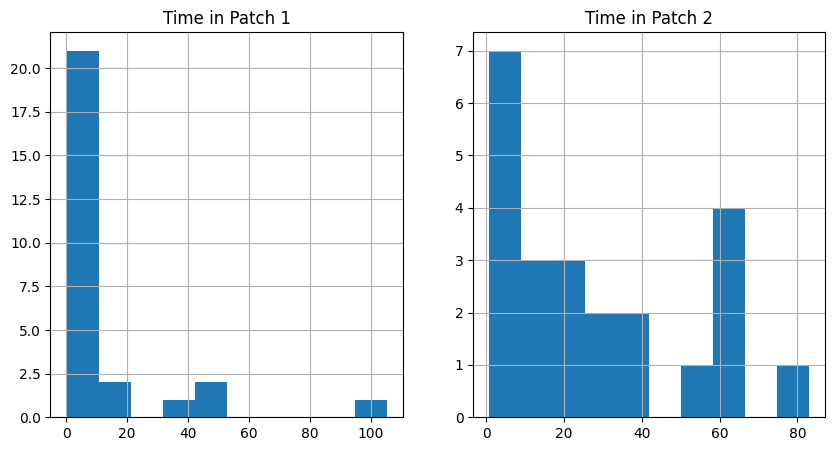

MSE: 497.22992594521014, R-squared: 0.014078196456267067
MSE: 547.0059166645576, R-squared: 0.05357632295522985


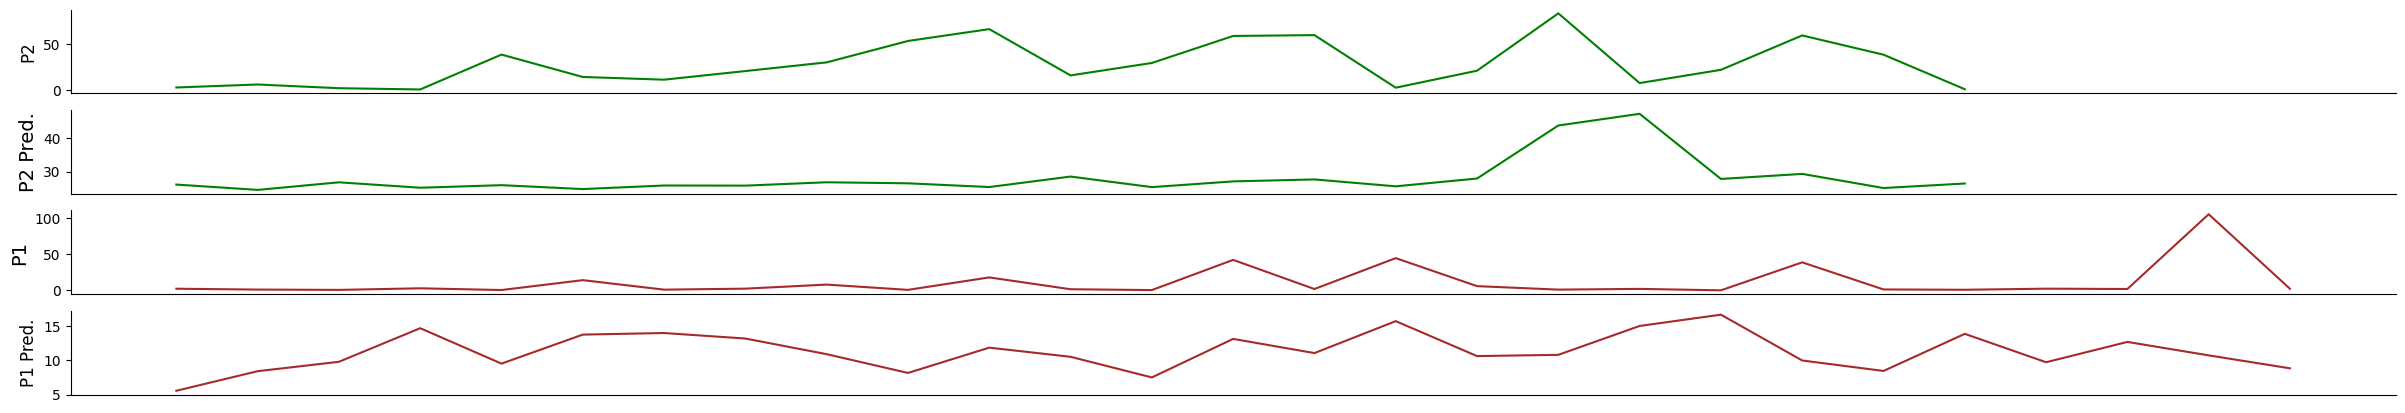

ShortSession1


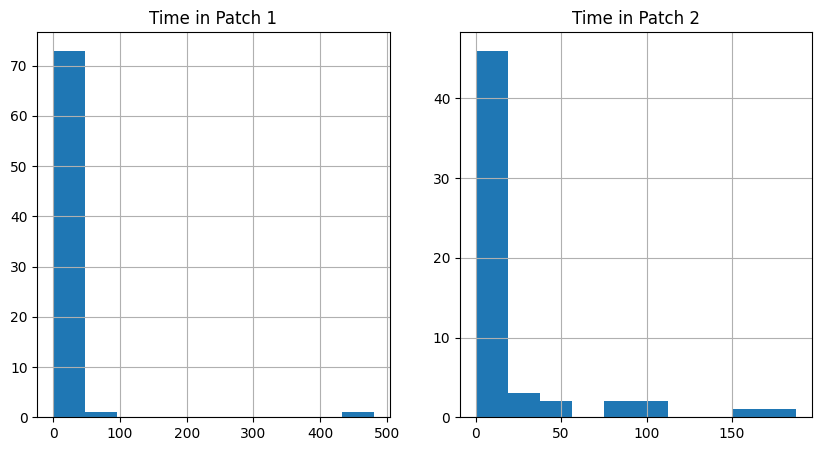

MSE: 2850.5789780192167, R-squared: 0.08549456333582606
MSE: 1170.2493579087268, R-squared: 0.20050018033992634


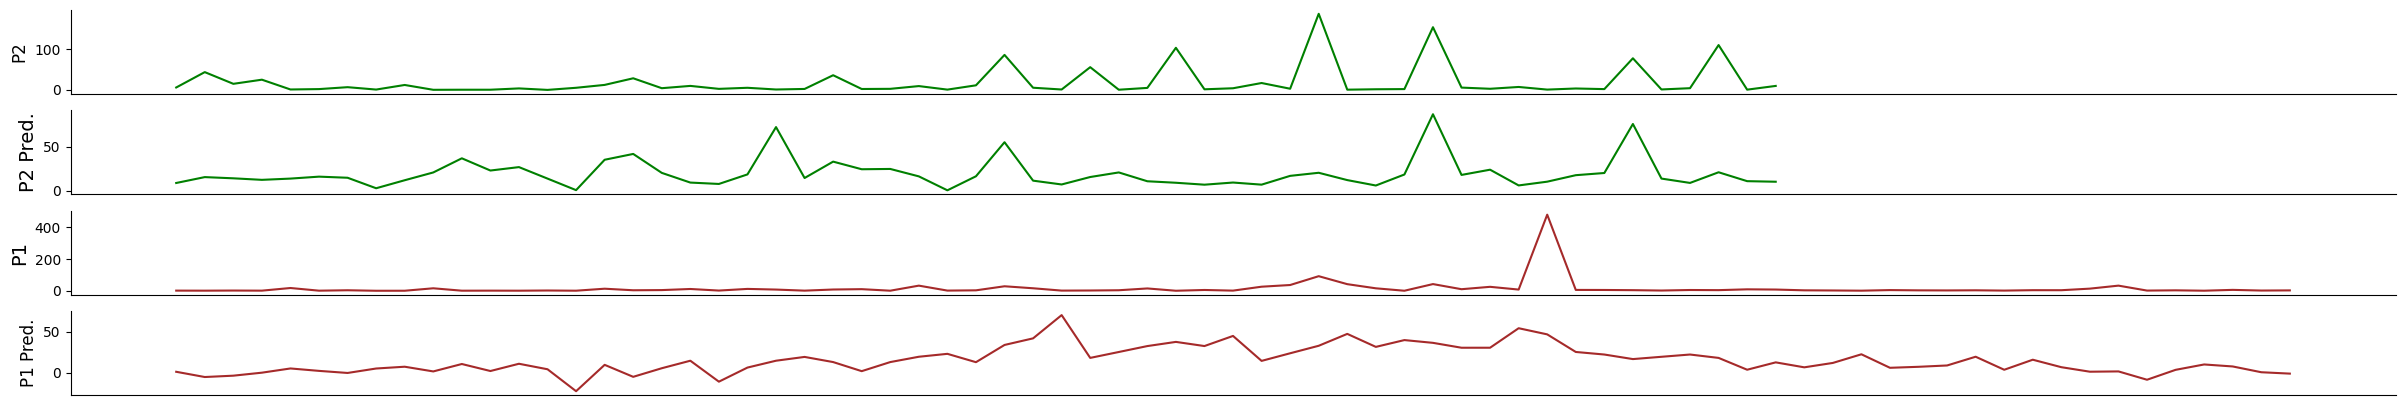

ShortSession2


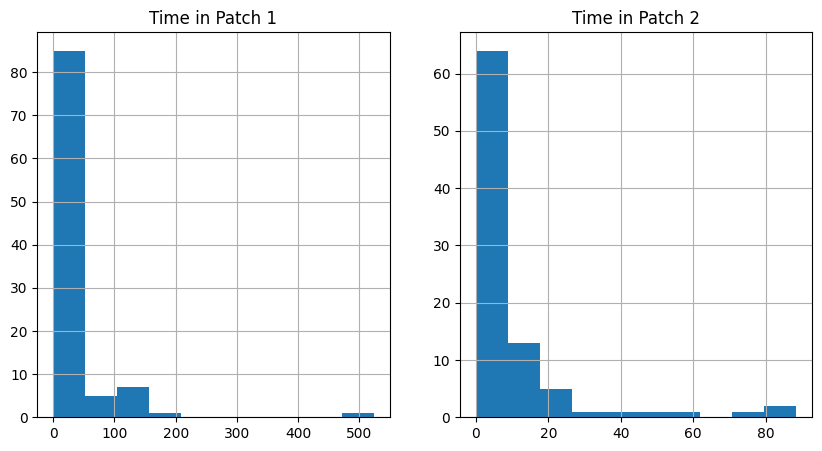

MSE: 3743.5711429334538, R-squared: 0.05781163943405354
MSE: 274.73499616660325, R-squared: 0.02887772831720159


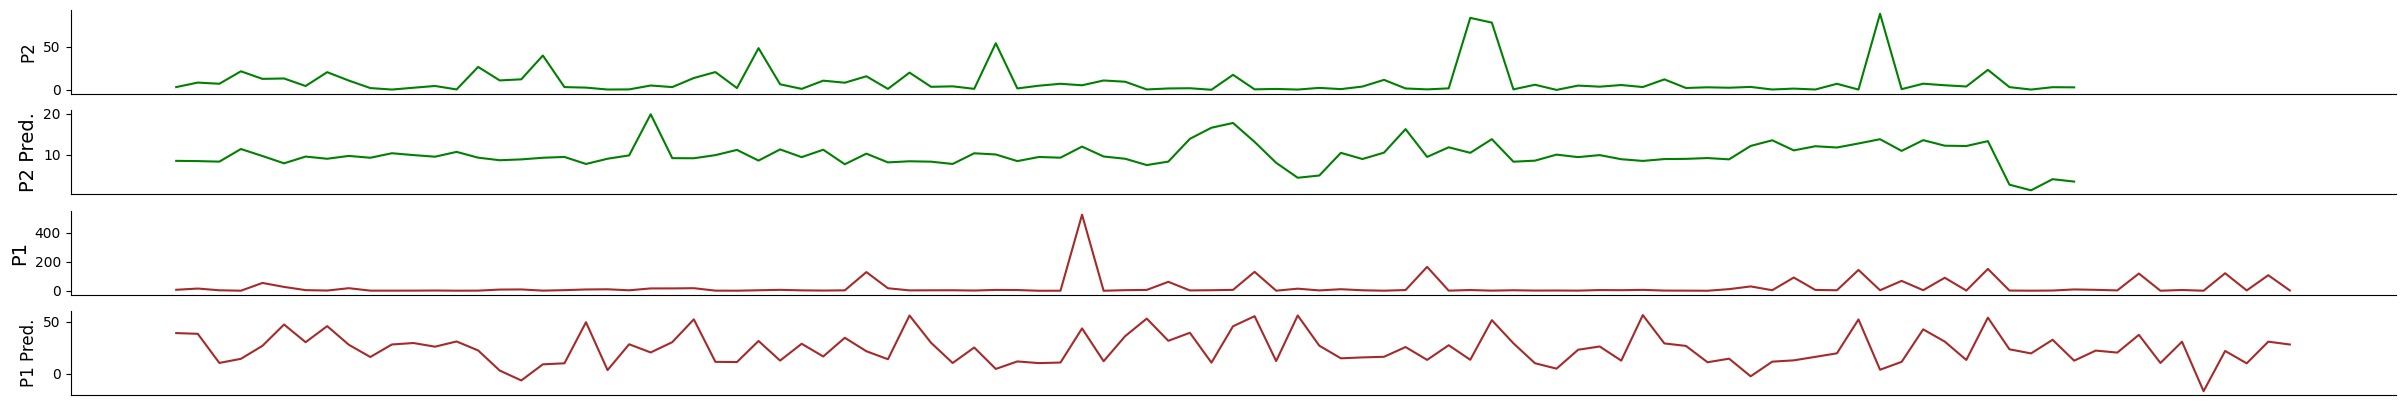

ShortSession3


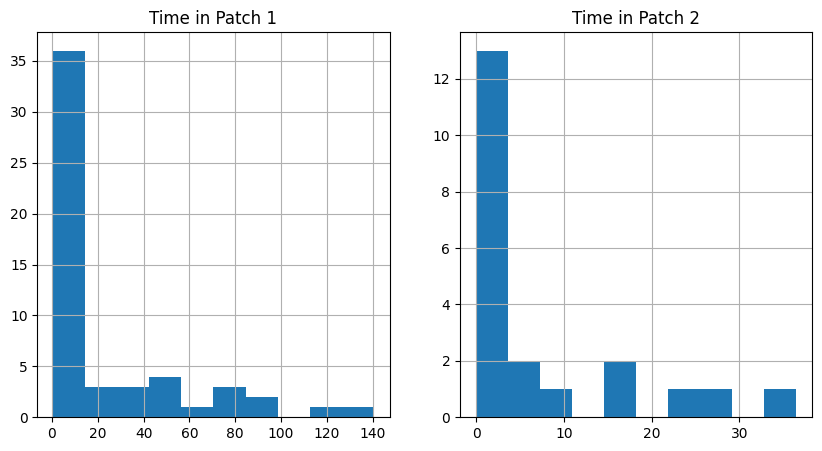

MSE: 992.5086839130212, R-squared: 0.08647094423669432
MSE: 73.469078747064, R-squared: 0.29338067768613396


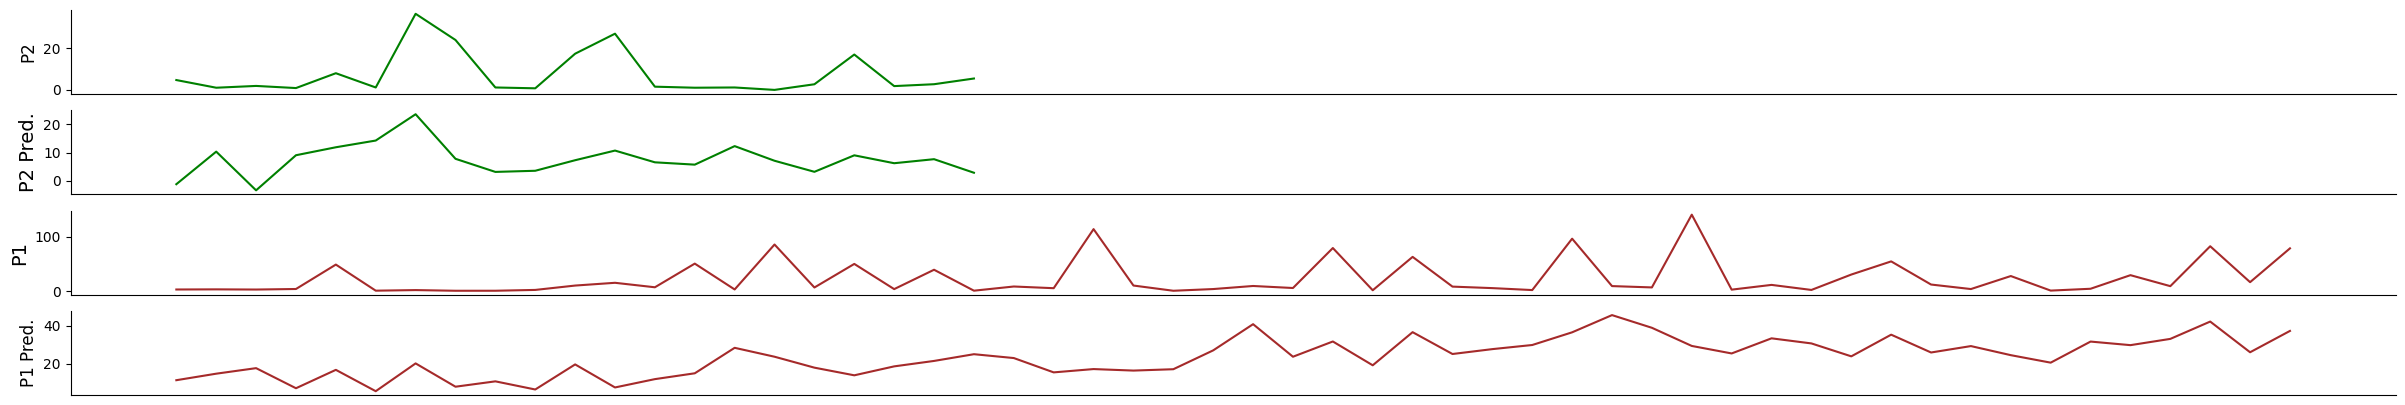

ShortSession4


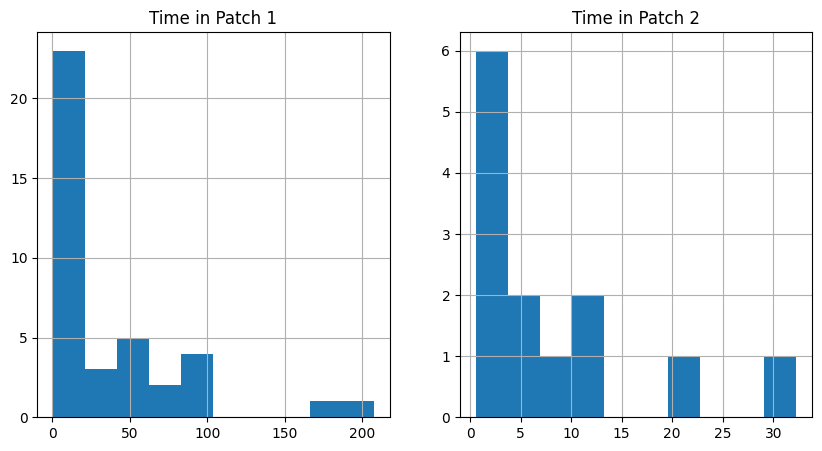

MSE: 1759.215991256779, R-squared: 0.24989618352927745
MSE: 63.33294903713622, R-squared: 0.2044539552402811


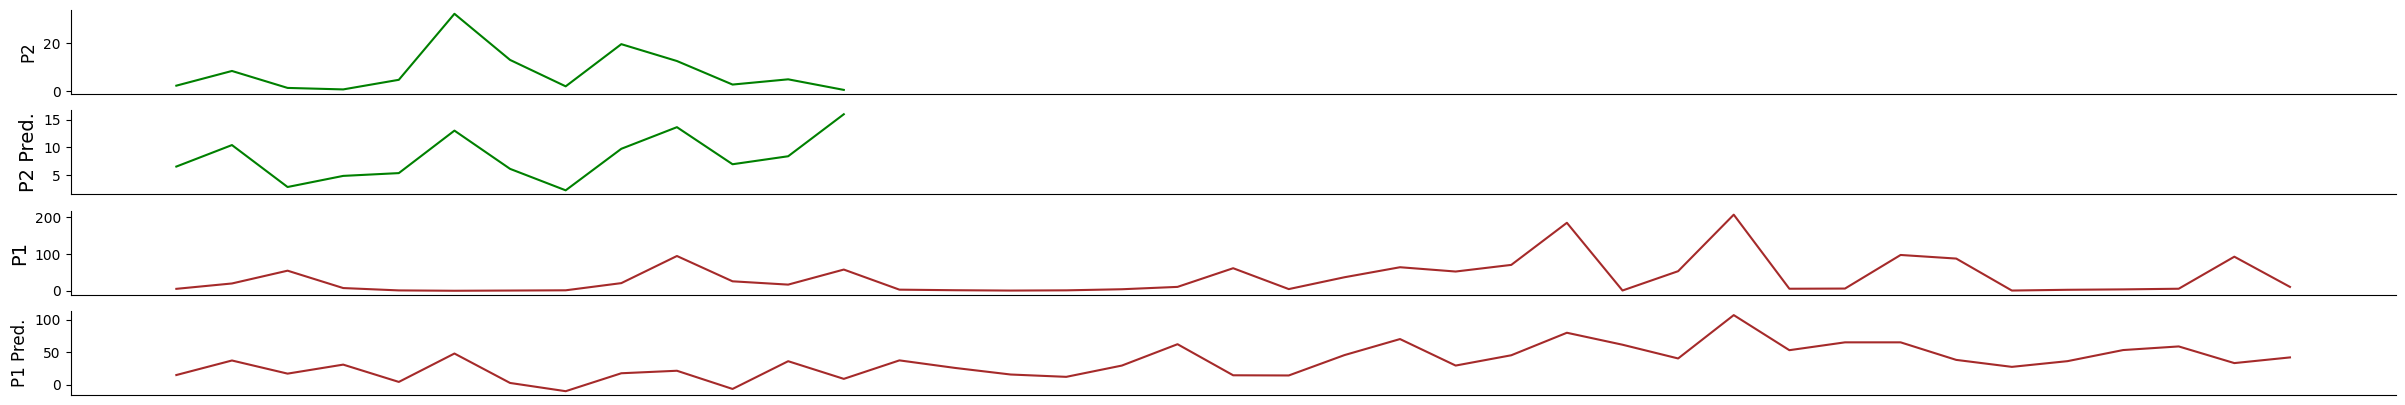

ShortSession5


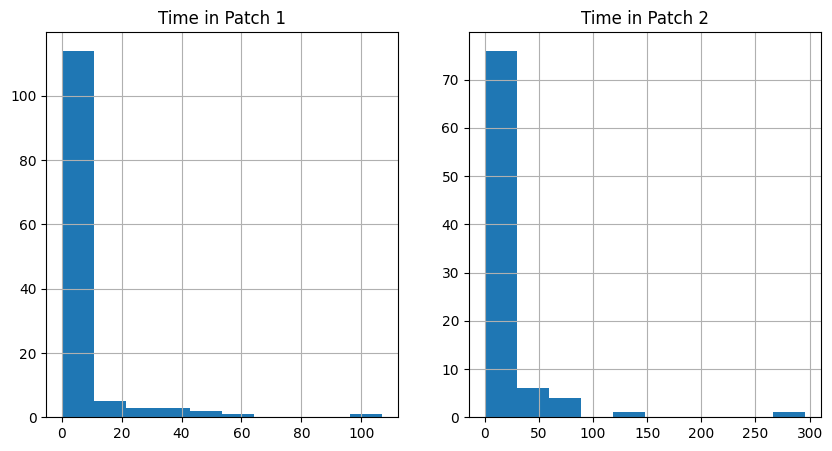

MSE: 174.94649238927022, R-squared: 0.015770860997266767
MSE: 1345.7584091546612, R-squared: 0.012907157052164275


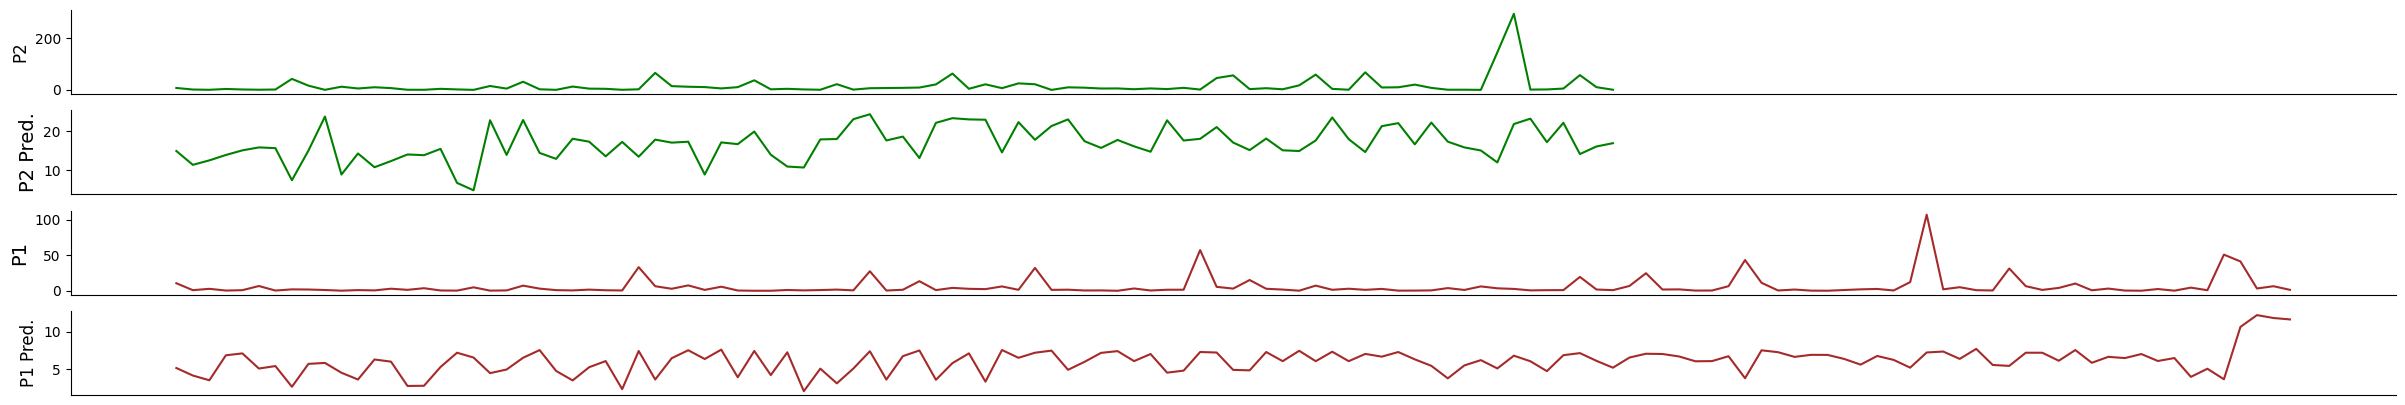

ShortSession6


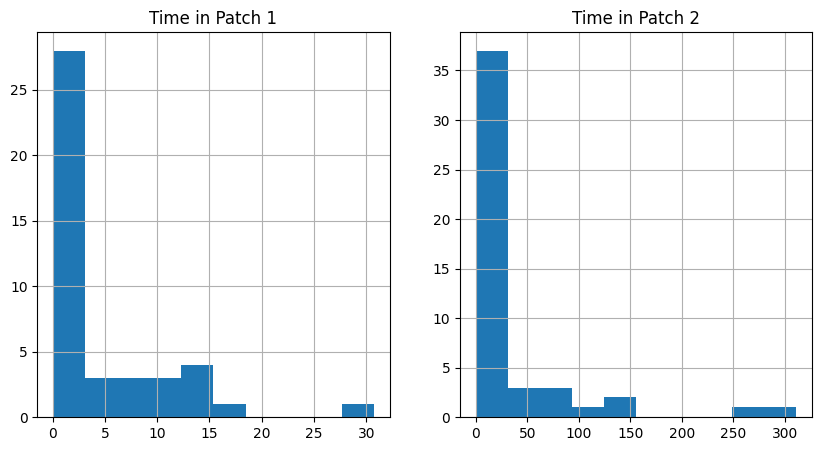

MSE: 39.944466101877815, R-squared: 0.033781108360965595
MSE: 3875.557566261464, R-squared: 0.02375909484164196


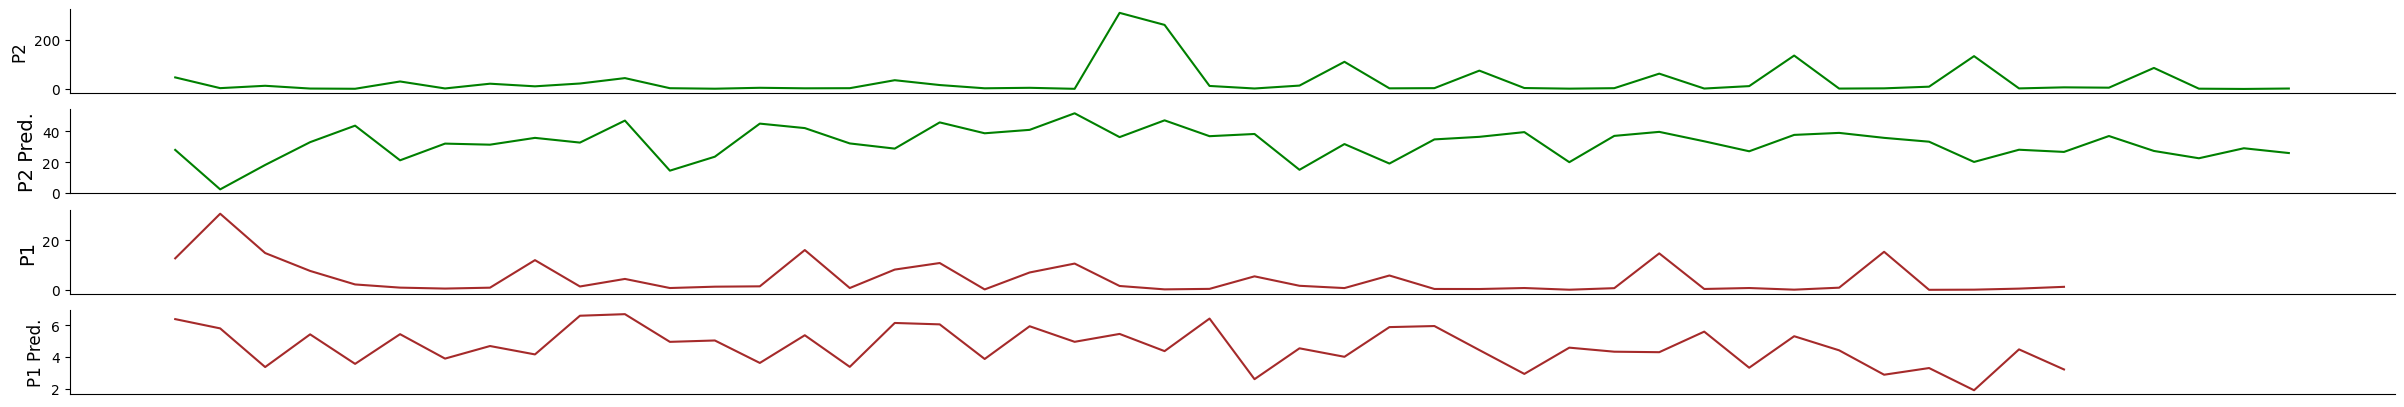

ShortSession7


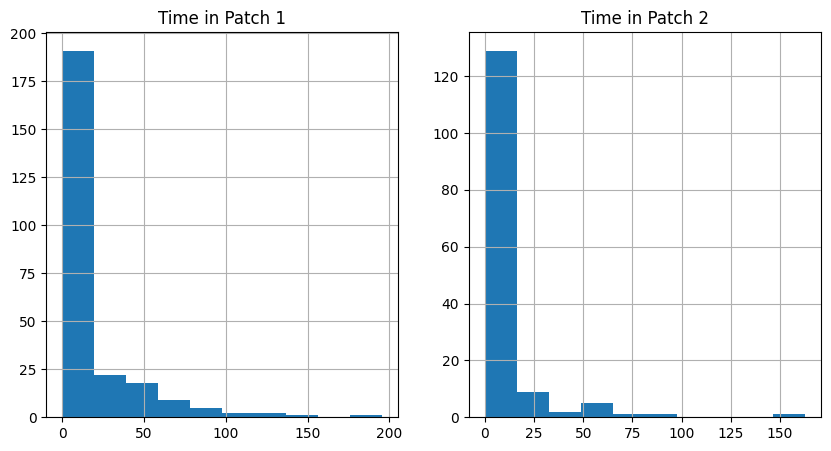

MSE: 758.4030868245761, R-squared: 0.05114126052557977
MSE: 369.54185059775244, R-squared: 0.016146627550644554


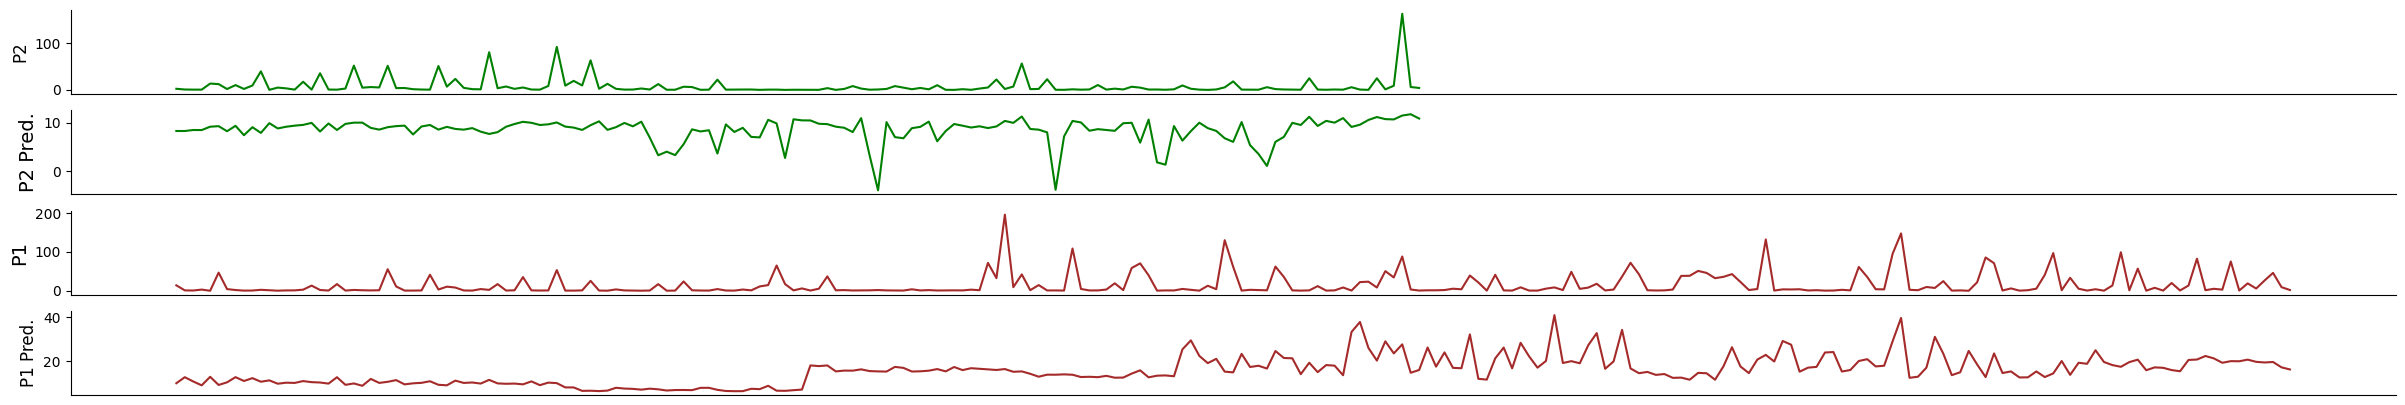

ShortSession8


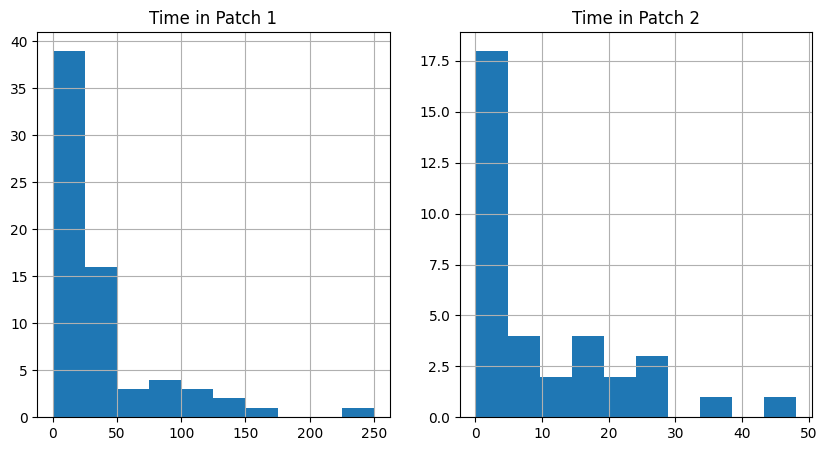

MSE: 1771.563517480278, R-squared: 0.1260190970155789
MSE: 138.03287239647096, R-squared: 0.037206303442202104


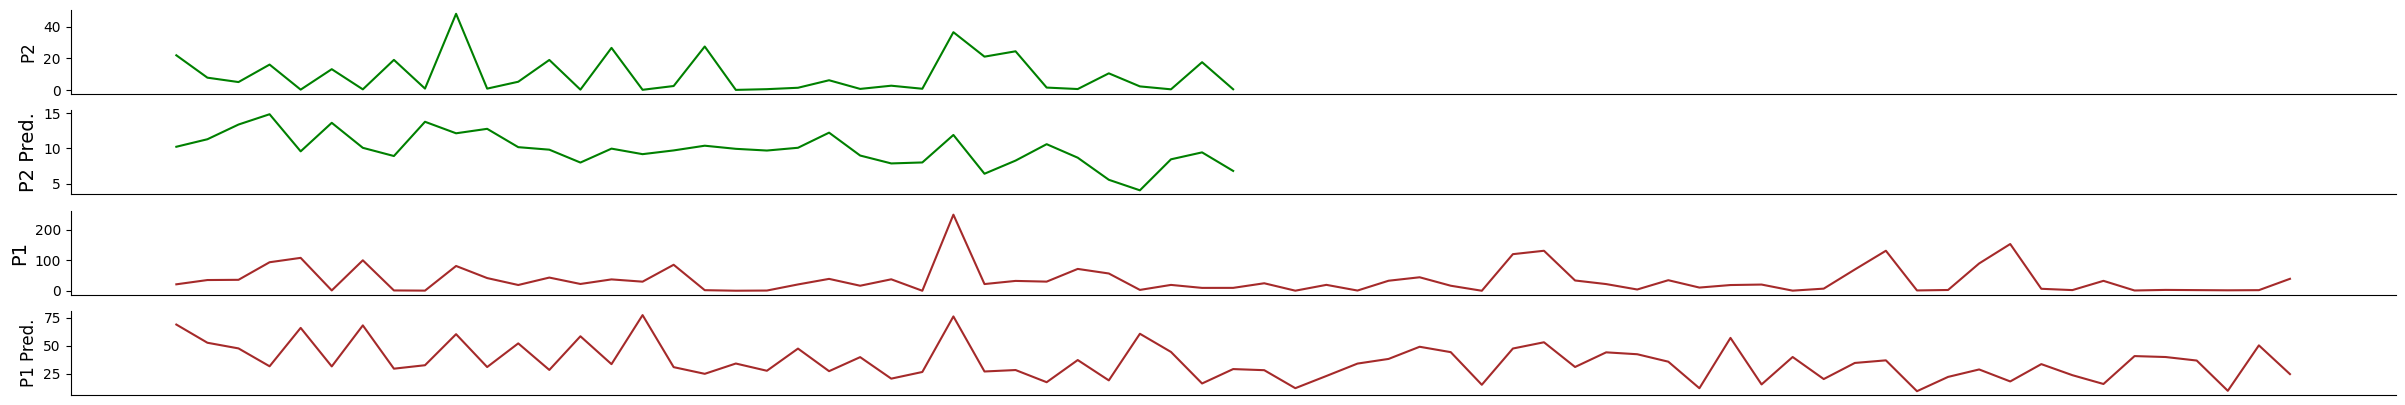

ShortSession9


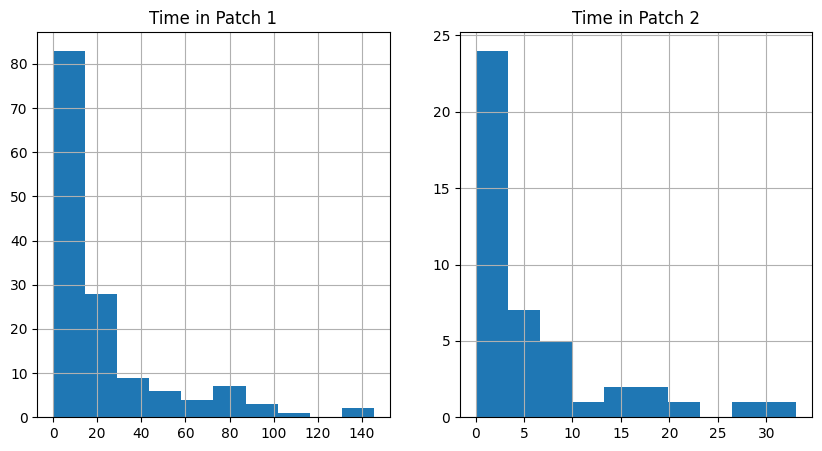

MSE: 684.4475224369667, R-squared: 0.14079593439302074
MSE: 54.673099785381446, R-squared: 0.09052249301628834


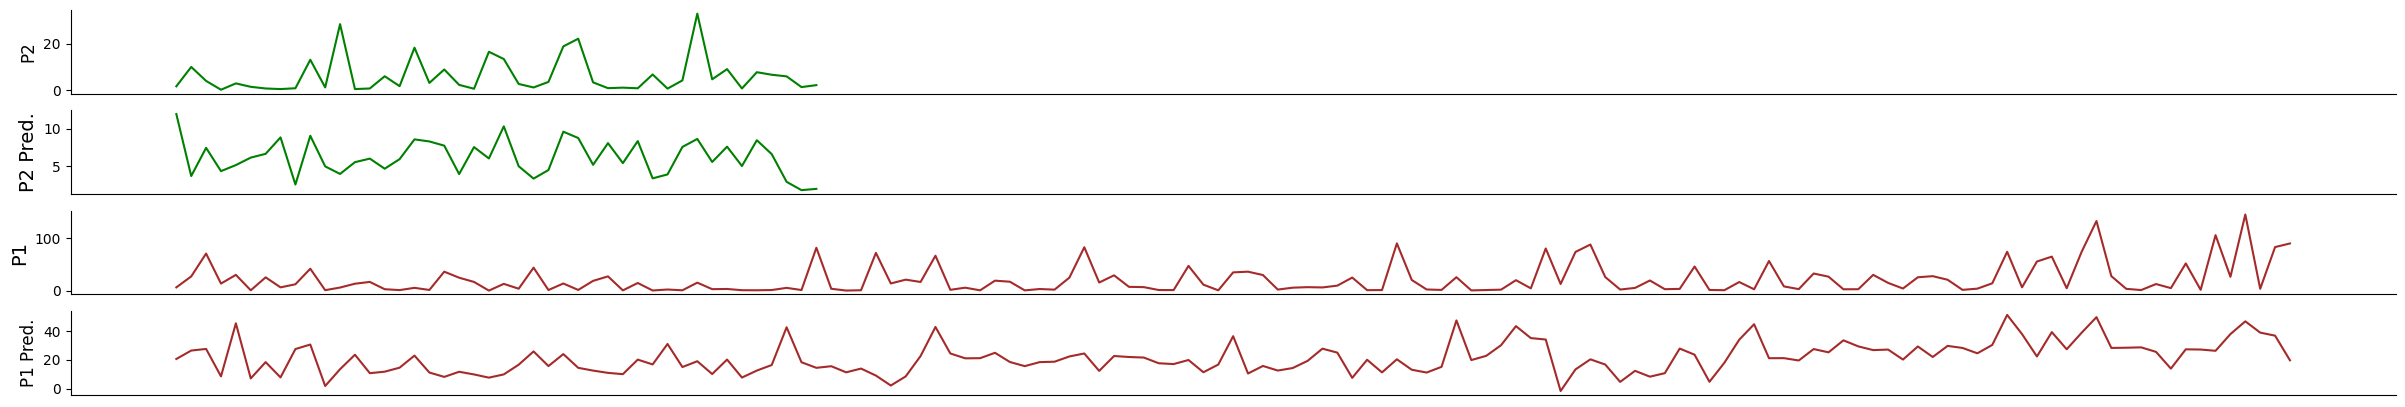

ShortSession10


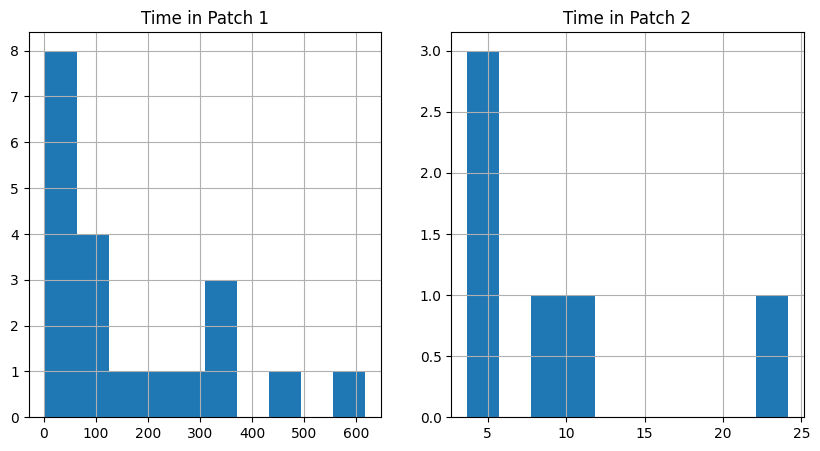

MSE: 23936.81341850942, R-squared: 0.1938142930523825
MSE: 1.4945758142925047, R-squared: 0.9692240799861486


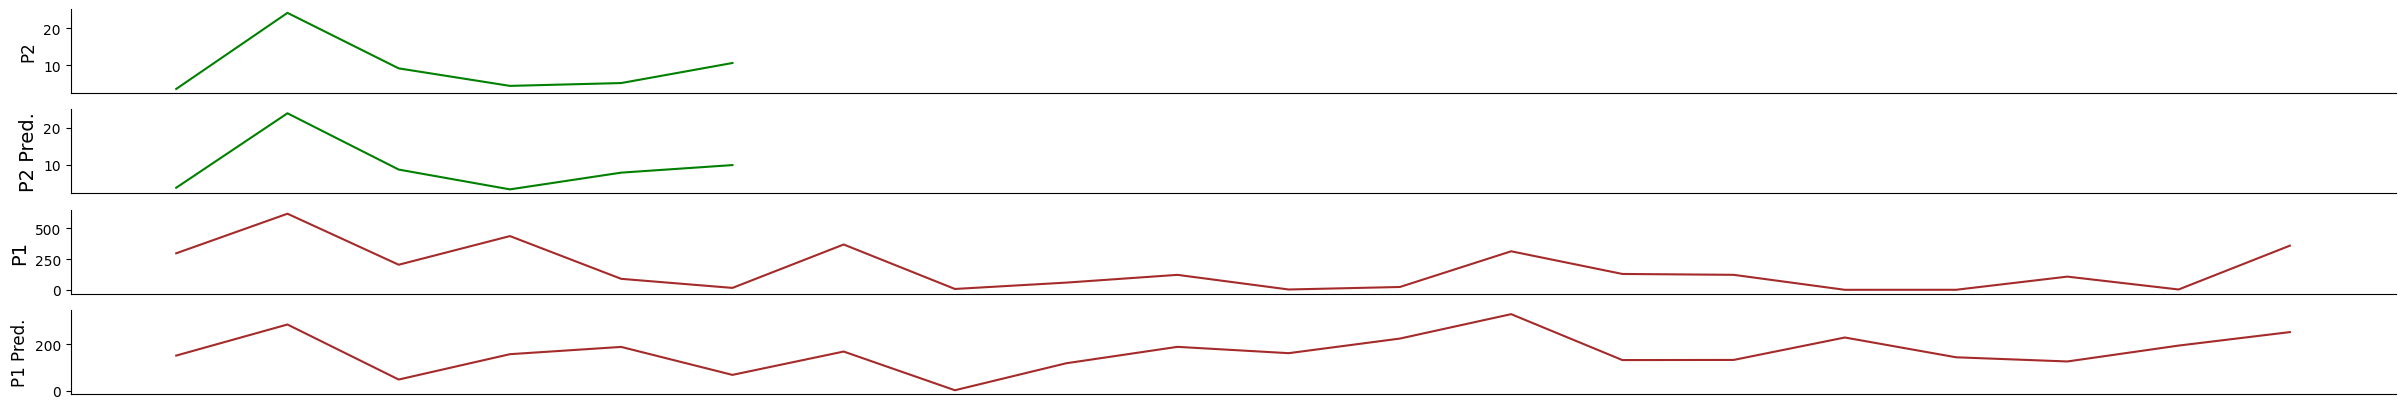

ShortSession11


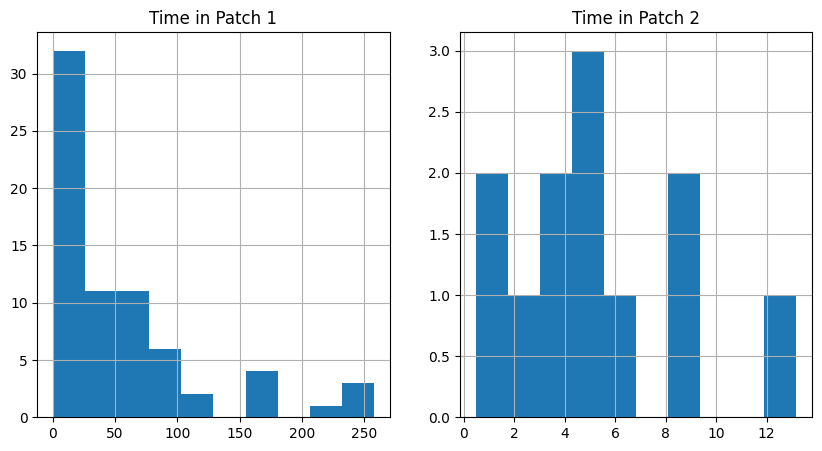

MSE: 2903.2378124992483, R-squared: 0.26198583219883
MSE: 8.367635464467556, R-squared: 0.3041654638251269


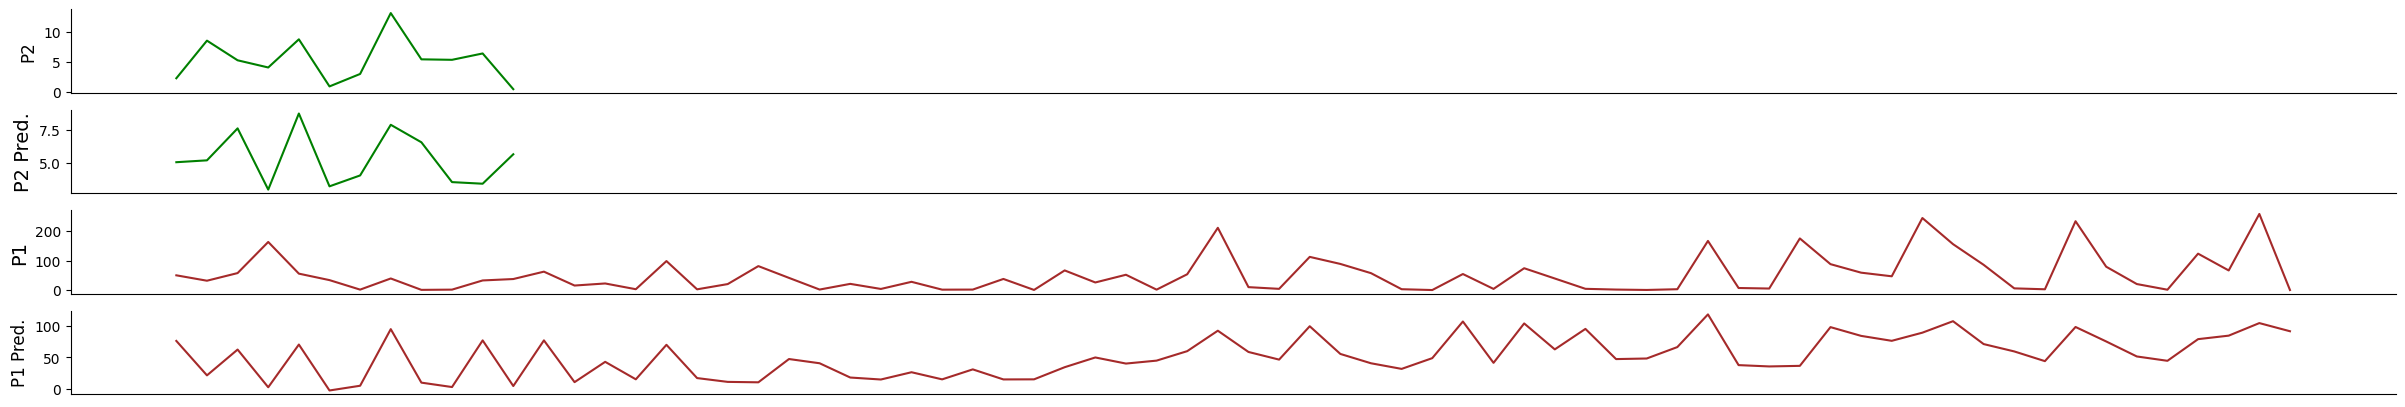

In [7]:
for session, i in zip(list(short_sessions.itertuples()), range(len(short_sessions))):
    title = 'ShortSession'+str(i)
    print(title)

    mouse_pos = pd.read_parquet(title+'mousepos.parquet', engine='pyarrow')
    
    Visits_Patch1 = patch.VisitPatch(mouse_pos, patch = 'Patch1', speed_ave_time = '10S', acce_ave_time = '10S', weight_ave_time = '10S')
    Visits_Patch2 = patch.VisitPatch(mouse_pos, patch='Patch2',speed_ave_time = '10S', acce_ave_time = '10S', weight_ave_time = '10S')
        
    fig, axs = plt.subplots(1,2,figsize = (10,5))
    Visits_Patch1.duration.hist(ax = axs[0])
    Visits_Patch2.duration.hist(ax = axs[1])
    axs[0].set_title('Time in Patch 1')
    axs[1].set_title('Time in Patch 2')
    plt.show()
        
    X1 = Visits_Patch1[['speed','acceleration', 'weight']]
    y1 = Visits_Patch1['duration']
    X2 = Visits_Patch2[['speed','acceleration', 'weight']]
    y2 = Visits_Patch2['duration']
    
    coefficients1, intercept1, y1_pred, mse1, r21 = patch.SimpleLinearRegression(X1, y1)
    print(f"MSE: {mse1}, R-squared: {r21}")
        
    coefficients2, intercept2, y2_pred, mse2, r22 = patch.SimpleLinearRegression(X2, y2)
    print(f"MSE: {mse2}, R-squared: {r22}")
        
    patch.ComparePrediction(y1, y1_pred, y2, y2_pred)
    
    np.savez(title + 'Regression.npz', 
             coefficients_1 = coefficients1, intercept_1 = intercept1, y1_pred = y1_pred, mse_1 = mse1, r2_1 = r21, 
             coefficients_2 = coefficients2, intercept_2 = intercept2, y2_pred = y2_pred, mse_2 = mse2, r2_2 = r22 )

## Coefficients

In [8]:
from sklearn.preprocessing import StandardScaler

ShortSession0


ShortSession1
ShortSession2
ShortSession3
ShortSession4
ShortSession5
ShortSession6
ShortSession7
ShortSession8
ShortSession9
ShortSession10
ShortSession11


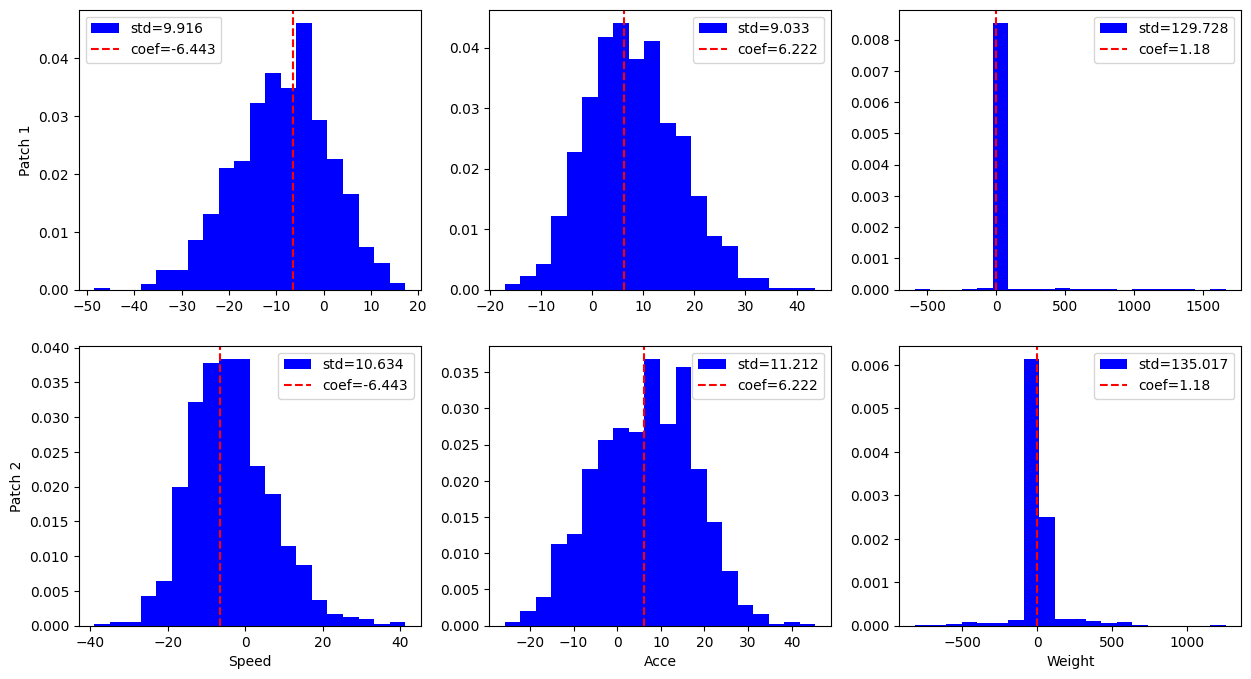

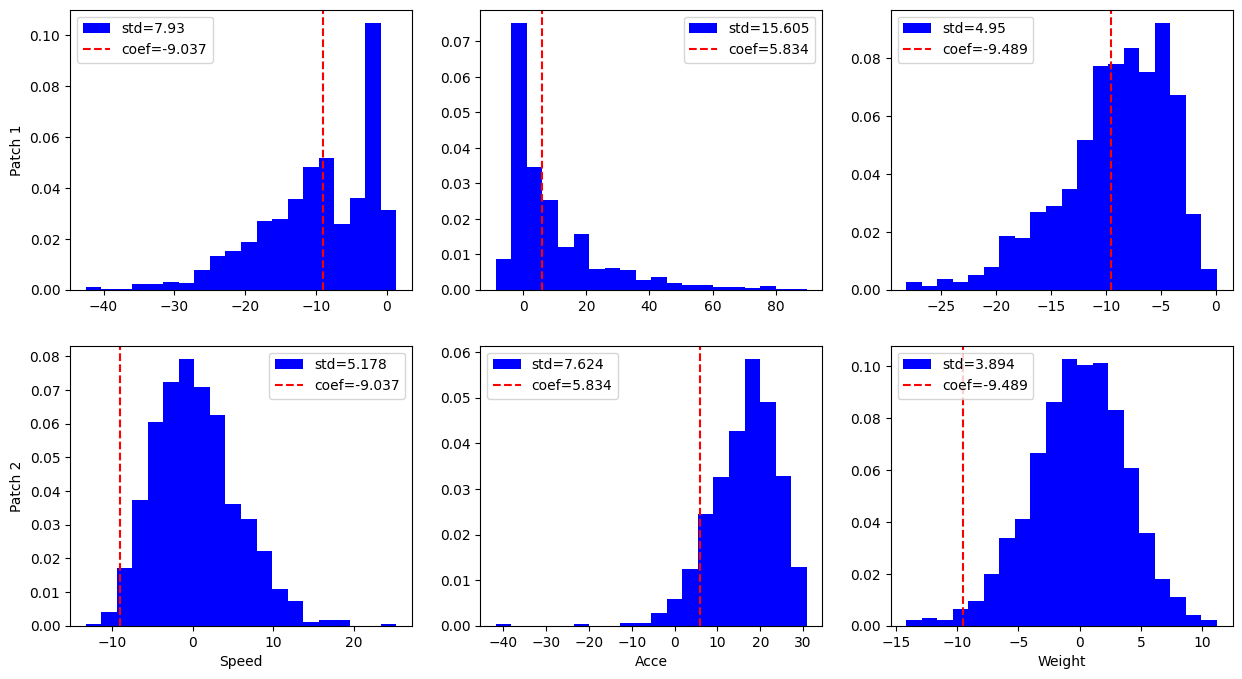

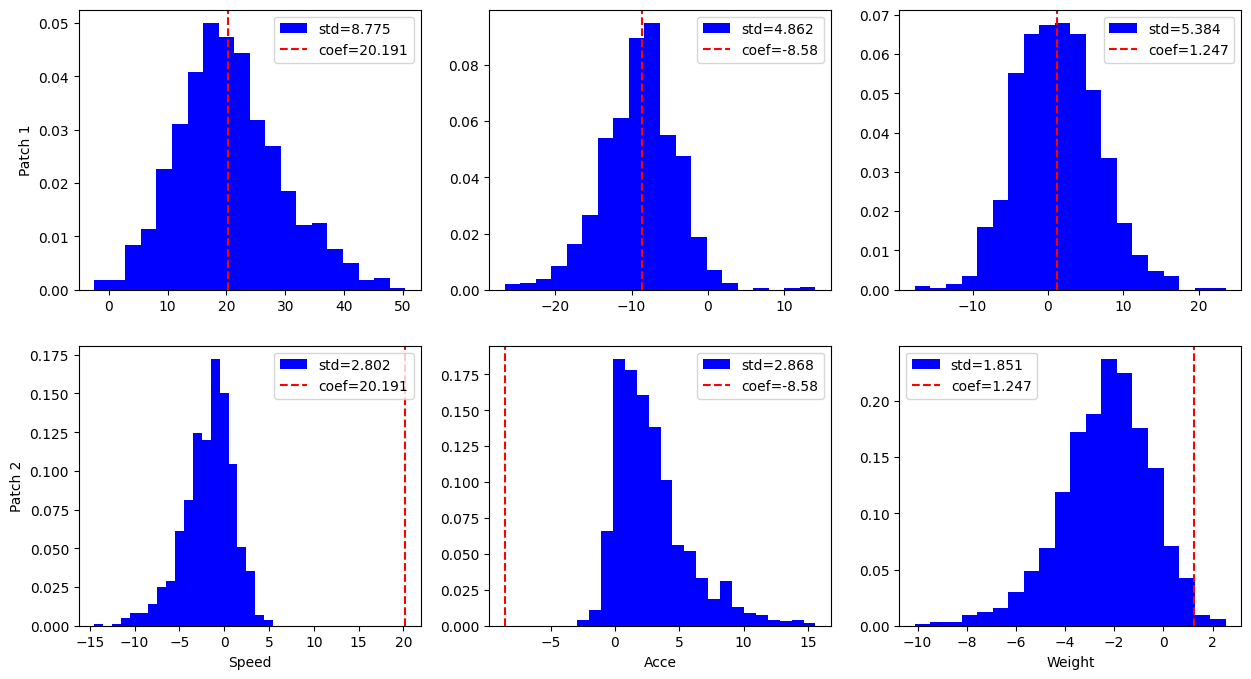

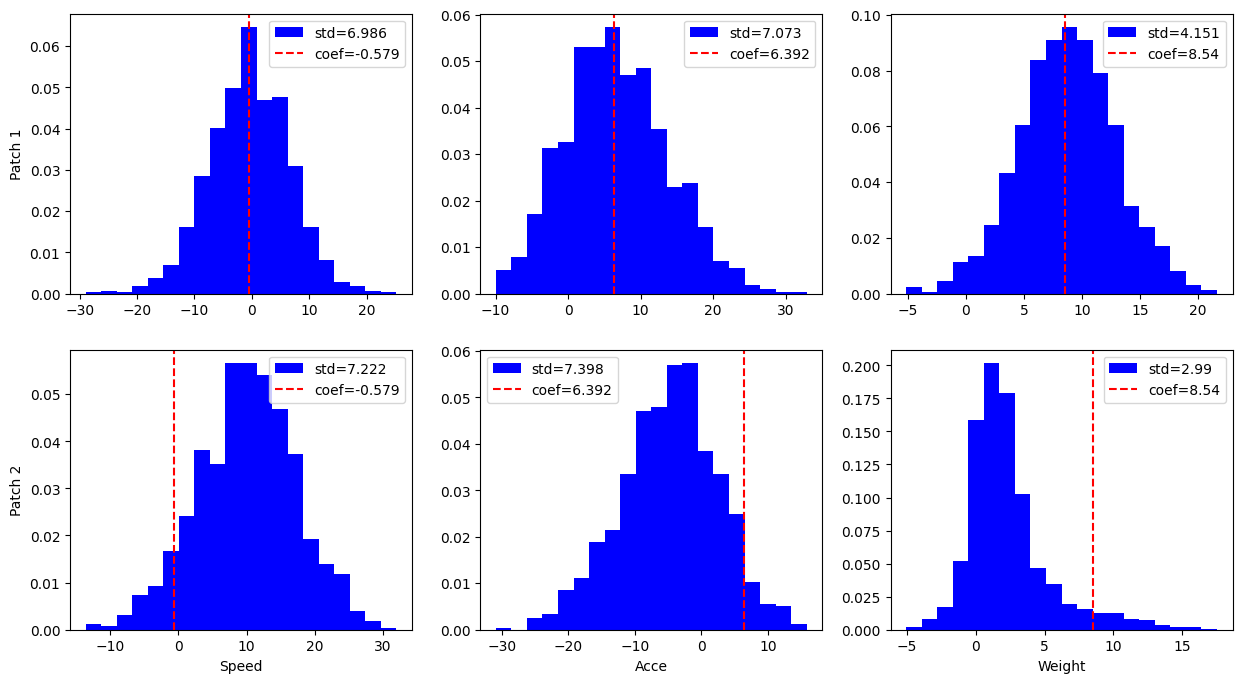

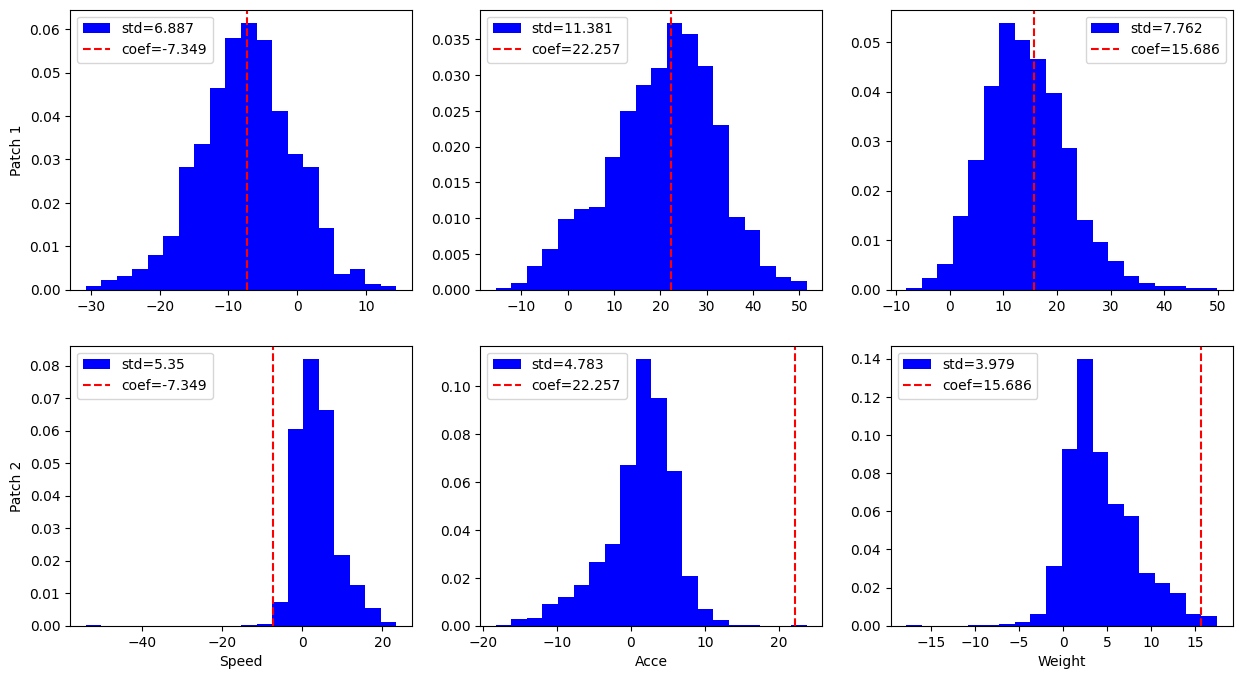

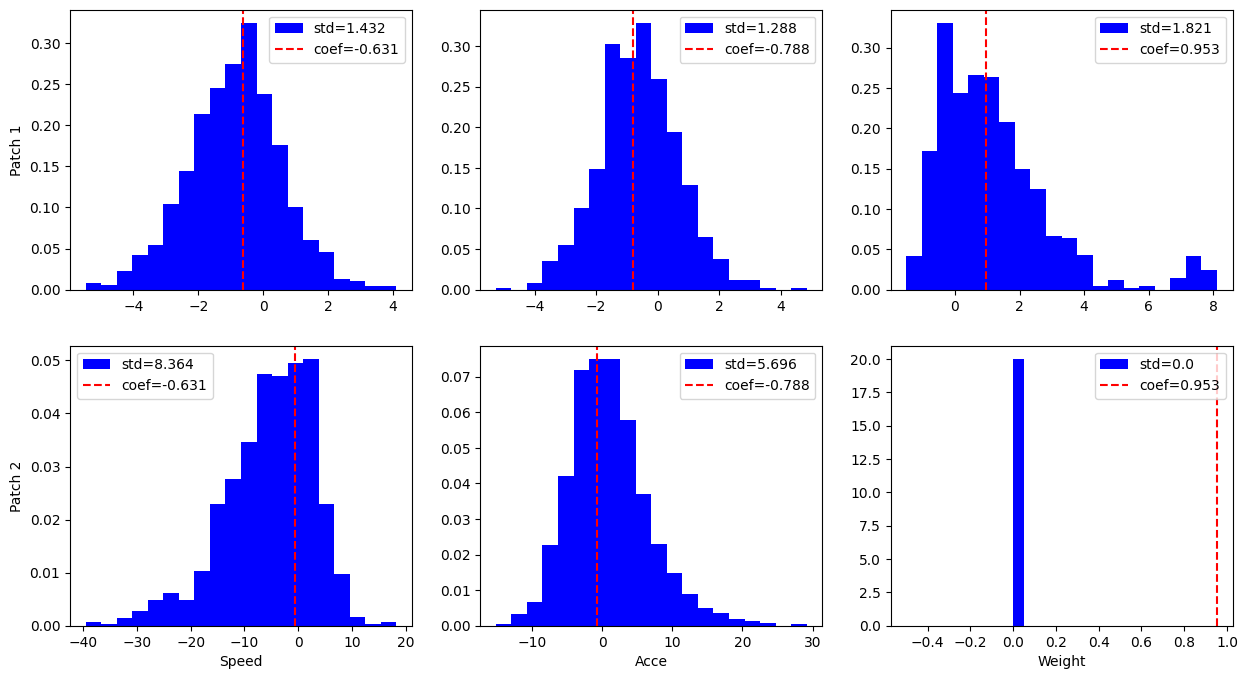

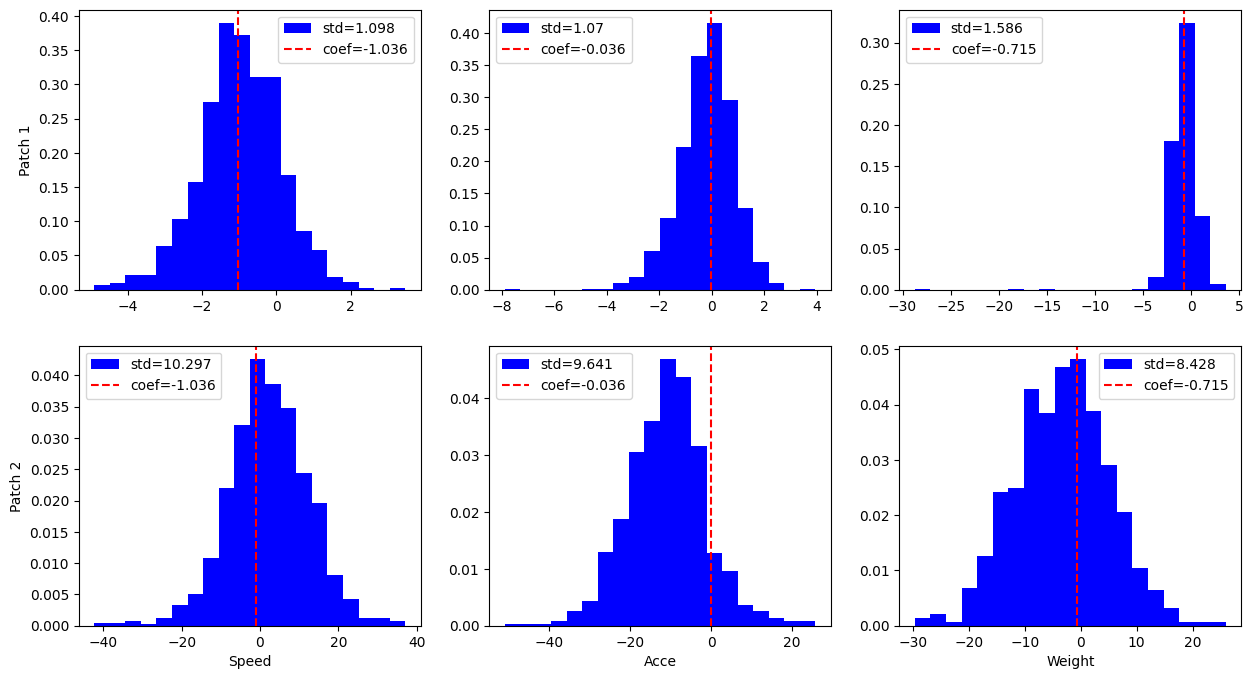

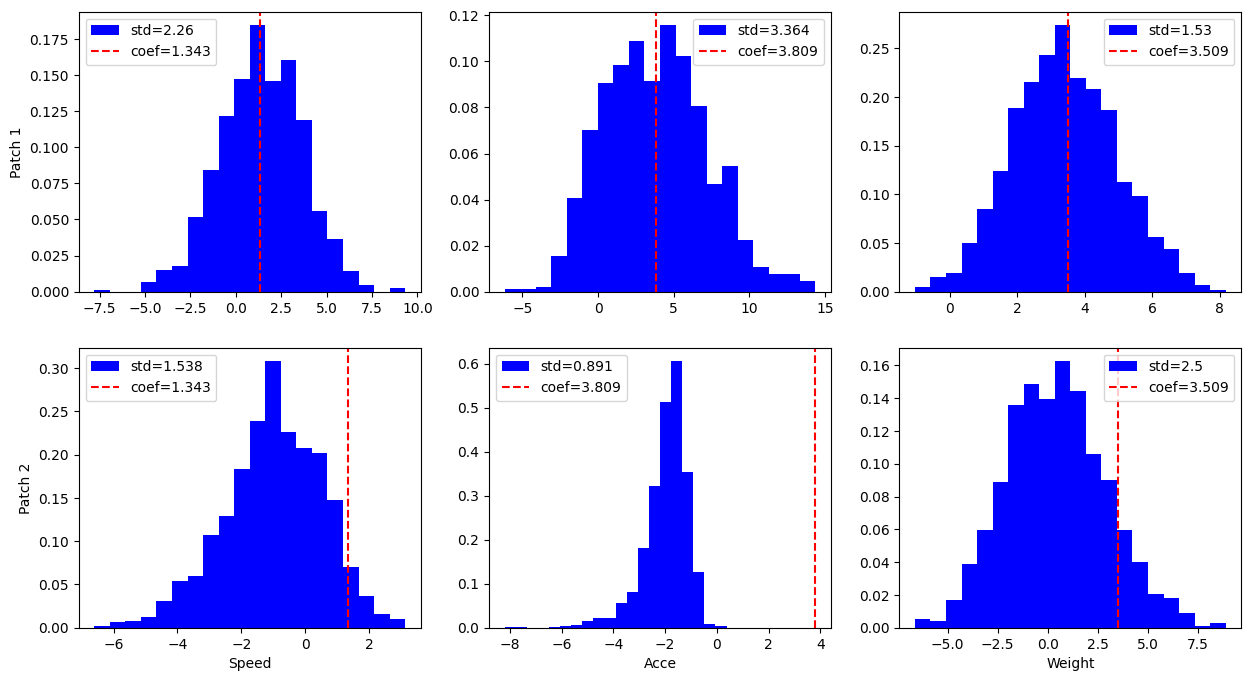

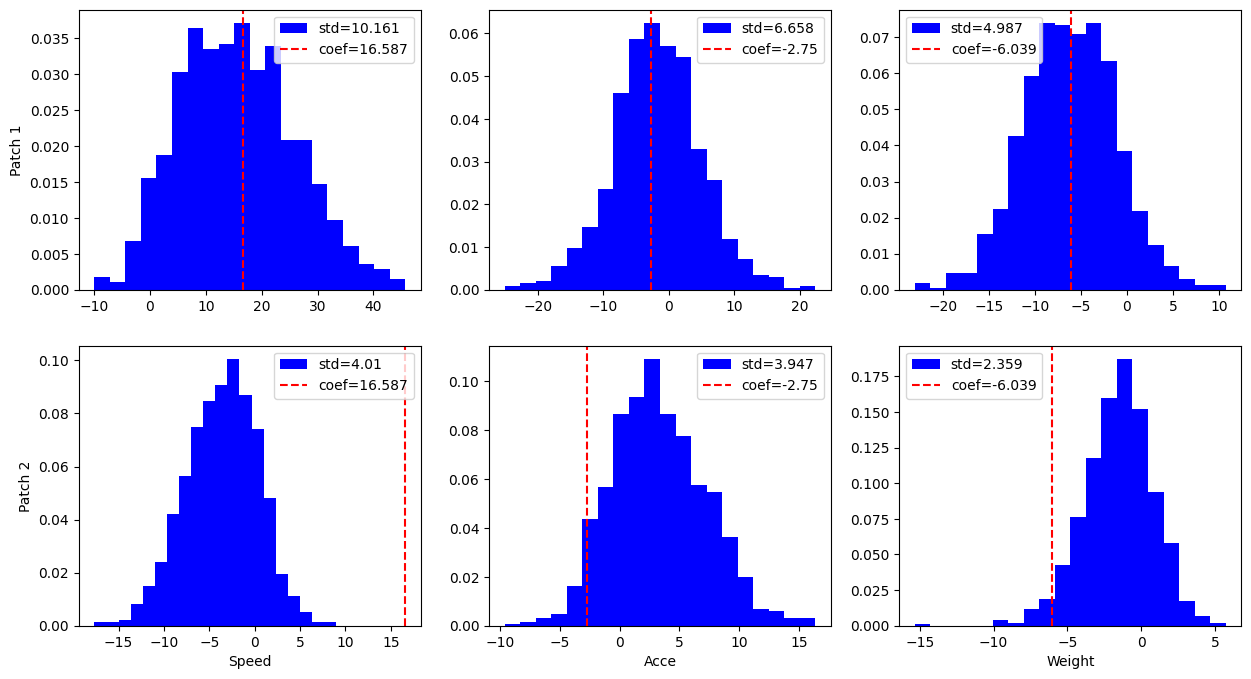

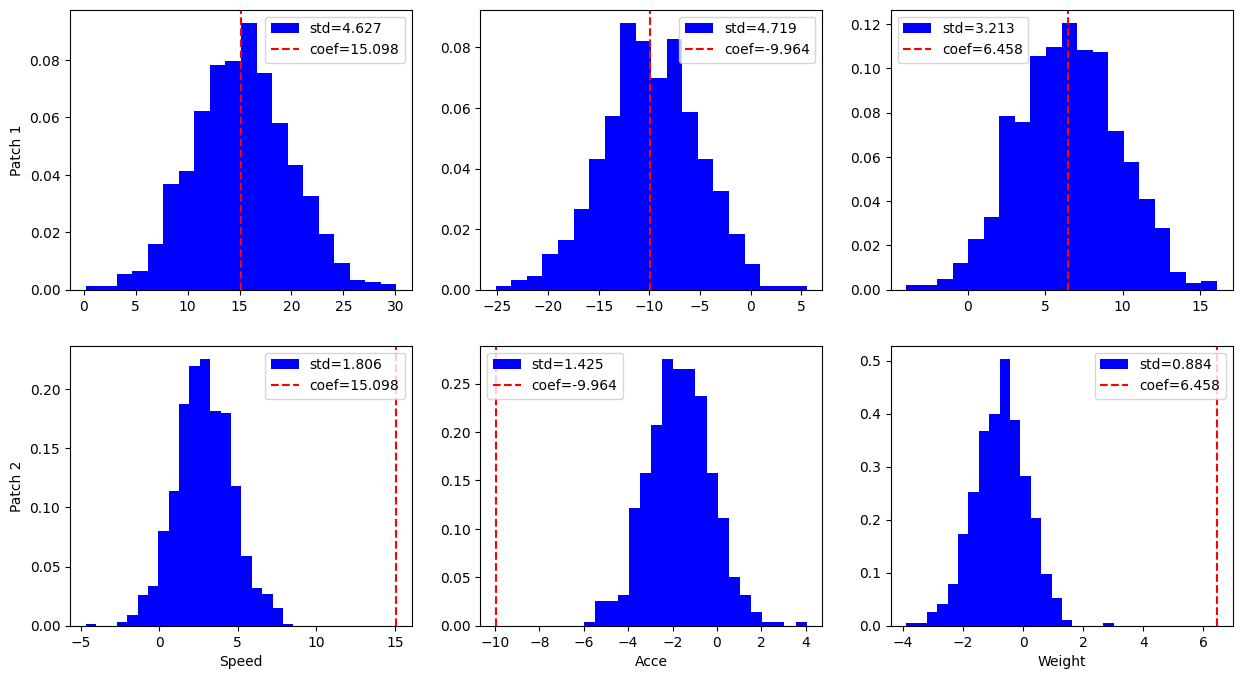

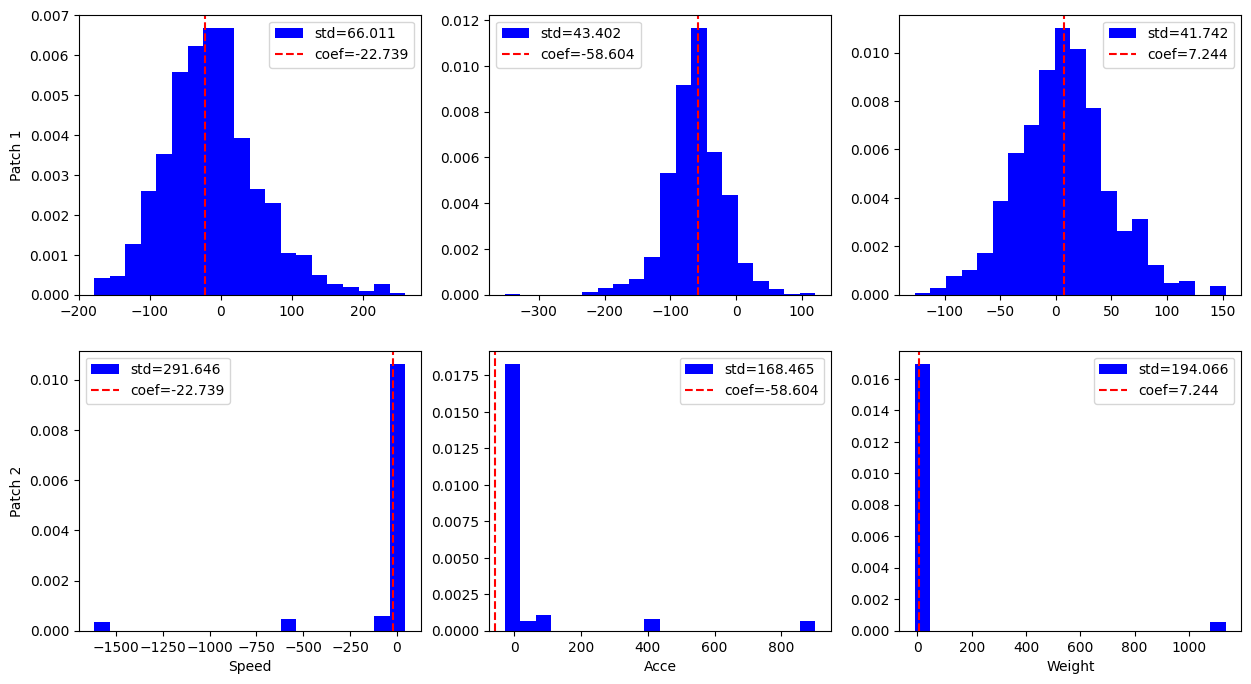

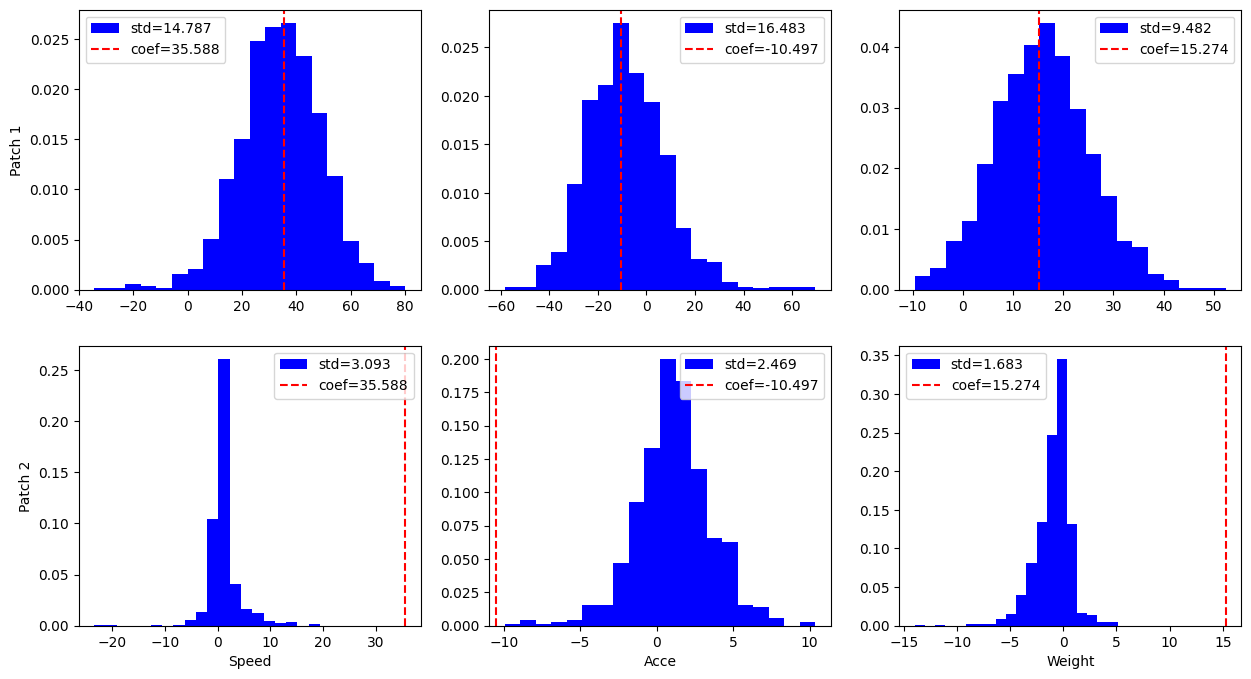

In [9]:
for session, i in zip(list(short_sessions.itertuples()), range(len(short_sessions))):
    coefficients_1 = []
    coefficients_2 = []
    
    title = 'ShortSession'+str(i)
    print(title)

    mouse_pos = pd.read_parquet(title+'mousepos.parquet', engine='pyarrow')
        
    Visits_Patch1 = patch.VisitPatch(mouse_pos, patch = 'Patch1', speed_ave_time = '10S', acce_ave_time = '10S', weight_ave_time = '10S')
    Visits_Patch2 = patch.VisitPatch(mouse_pos, patch='Patch2',speed_ave_time = '10S', acce_ave_time = '10S', weight_ave_time = '10S')
            
    X1 = Visits_Patch1[['speed','acceleration', 'weight']]
    y1 = Visits_Patch1['duration']
    X2 = Visits_Patch2[['speed','acceleration', 'weight']]
    y2 = Visits_Patch2['duration']
    
    scaler = StandardScaler()
    X1 = scaler.fit_transform(X1)
    scaler = StandardScaler()
    X2 = scaler.fit_transform(X2)
        
    coefficient1, intercept1, y1_pred, mse1, r21 = patch.SimpleLinearRegression(X1, y1)
    coefficient2, intercept2, y2_pred, mse2, r22 = patch.SimpleLinearRegression(X2, y2)
        
    for t in range (1000):
        index = np.random.choice(np.arange(len(y1)), size=len(y1), replace=True)
        coefficients1, intercept1, y1_pred, mse1, r21 = patch.SimpleLinearRegression(X1[index], y1[index])
        index = np.random.choice(np.arange(len(y2)), size=len(y2), replace=True)
        coefficients2, intercept2, y2_pred, mse2, r22 = patch.SimpleLinearRegression(X2[index], y2[index])
        coefficients_1.append(coefficients1)
        coefficients_2.append(coefficients2)
    coefficients_1, coefficients_2 = np.array(coefficients_1), np.array(coefficients_2)
    
    FEATURE = ['Speed', 'Acce', 'Weight']
    fig, axs = plt.subplots(2,3,figsize = (15,8))
    for j in range(3):
        axs[0,j].hist(coefficients_1.T[j], color = 'blue', bins = 20, density = True, label = 'std='+str(round(np.std(coefficients_1.T[j]), 3)))
        axs[0,j].axvline(coefficient1[j], color = 'red', linestyle = '--', label = 'coef='+str(round(coefficient1[j], 3)))
        axs[0,j].legend()
        axs[1,j].hist(coefficients_2.T[j], color = 'blue', bins = 20, density = True, label = 'std='+str(round(np.std(coefficients_2.T[j]), 3)))
        axs[1,j].axvline(coefficient1[j], color = 'red', linestyle = '--', label = 'coef='+str(round(coefficient1[j], 3)))
        axs[1,j].legend()
        axs[1,j].set_xlabel(FEATURE[j])
    axs[0,0].set_ylabel('Patch 1')
    axs[1,0].set_ylabel('Patch 2')
    plt.savefig('/nfs/nhome/live/zimol/ProjectAeon/aeon_mecha/images/Regression/'+title+'.png')

ShortSession0
ShortSession1
ShortSession2
ShortSession3
ShortSession4
ShortSession5
ShortSession6
ShortSession7
ShortSession8
ShortSession9
ShortSession10
ShortSession11


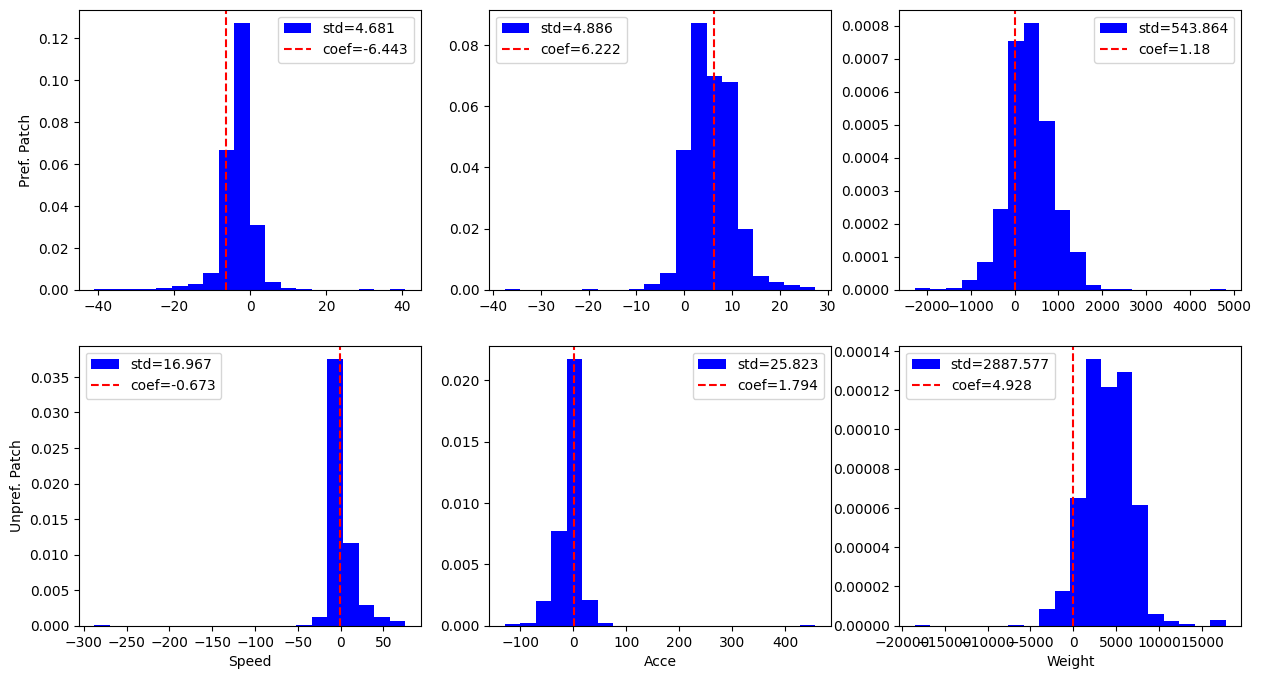

In [10]:
X_Pref, y_Pref = [], []
X_UnPref, y_UnPref = [], []

for session, i in zip(list(short_sessions.itertuples()), range(len(short_sessions))):
    coefficients_1 = []
    coefficients_2 = []
    
    title = 'ShortSession'+str(i)
    print(title)

    mouse_pos = pd.read_parquet(title+'mousepos.parquet', engine='pyarrow')
        
    Visits_Patch1 = patch.VisitPatch(mouse_pos, patch = 'Patch1', speed_ave_time = '10S', acce_ave_time = '10S', weight_ave_time = '10S')
    Visits_Patch2 = patch.VisitPatch(mouse_pos, patch='Patch2',speed_ave_time = '10S', acce_ave_time = '10S', weight_ave_time = '10S')
            
    X1 = Visits_Patch1[['speed','acceleration', 'weight']]
    y1 = Visits_Patch1['duration']
    X2 = Visits_Patch2[['speed','acceleration', 'weight']]
    y2 = Visits_Patch2['duration']
    
    scaler = StandardScaler()
    X1 = scaler.fit_transform(X1)
    scaler = StandardScaler()
    X2 = scaler.fit_transform(X2)
    
    if len(y1) > len(y2):
        X_Pref.append(X1)
        y_Pref.append(y1)
        X_UnPref.append(X2)
        y_UnPref.append(y2)
    else: 
        X_Pref.append(X2)
        y_Pref.append(y2)
        X_UnPref.append(X1)
        y_UnPref.append(y1)
        
coefficient1, intercept1, y1_pred, mse1, r21 = patch.SimpleLinearRegression(X_Pref[0], y_Pref[0])
coefficient2, intercept2, y2_pred, mse2, r22 = patch.SimpleLinearRegression(X_UnPref[0], y_UnPref[0])
        
for t in range (1000):
    index = np.random.choice(np.arange(len(y_Pref)), size=len(y_Pref), replace=True)
    coefficients1, intercept1, y1_pred, mse1, r21 = patch.SimpleLinearRegression(X_Pref[0][index], y_Pref[0][index])
    
    index = np.random.choice(np.arange(len(y_UnPref)), size=len(y_UnPref), replace=True)
    coefficients2, intercept2, y2_pred, mse2, r22 = patch.SimpleLinearRegression(X_UnPref[0][index], y_UnPref[0][index])
    
    coefficients_1.append(coefficients1)
    coefficients_2.append(coefficients2)
coefficients_1, coefficients_2 = np.array(coefficients_1), np.array(coefficients_2)
    
FEATURE = ['Speed', 'Acce', 'Weight']
fig, axs = plt.subplots(2,3,figsize = (15,8))
for j in range(3):
    axs[0,j].hist(coefficients_1.T[j], color = 'blue', bins = 20, density = True, label = 'std='+str(round(np.std(coefficients_1.T[j]), 3)))
    axs[0,j].axvline(coefficient1[j], color = 'red', linestyle = '--', label = 'coef='+str(round(coefficient1[j], 3)))
    axs[0,j].legend()
    axs[1,j].hist(coefficients_2.T[j], color = 'blue', bins = 20, density = True, label = 'std='+str(round(np.std(coefficients_2.T[j]), 3)))
    axs[1,j].axvline(coefficient2[j], color = 'red', linestyle = '--', label = 'coef='+str(round(coefficient2[j], 3)))
    axs[1,j].legend()
    axs[1,j].set_xlabel(FEATURE[j])
axs[0,0].set_ylabel('Pref. Patch')
axs[1,0].set_ylabel('Unpref. Patch')
plt.show()

# Time in Patch: Simple Linear Regression - Long Sessions

In [8]:
# Compute and Save Patch Information
for session, i in zip(list(long_sessions.itertuples()), range(len(long_sessions))):
    if i < 3:
        title = 'LongSession'+str(i)
        print(title)
                        
        start, end = session.enter, session.exit
        mouse_pos = api.load(root, exp02.CameraTop.Position, start=start, end=end)
        mouse_pos = kinematics.ProcessRawData(mouse_pos, root, start, end)
                
        start, end = mouse_pos.index[0], mouse_pos.index[-1]
                    
        patch.AddKinematics(title, mouse_pos)
        
        mouse_pos = mouse_pos[mouse_pos['smoothed_speed'] <= 2000]
                
        weight = api.load(root, exp02.Nest.WeightSubject, start=start, end=end)
        patch.AddWeight(mouse_pos, weight)
                
        pellets_patch1 = api.load(root, exp02.Patch1.DeliverPellet, start=start, end=end)
        pellets_patch2 = api.load(root, exp02.Patch2.DeliverPellet, start=start, end=end)
                    
        patch.InPatch(mouse_pos, pellets_patch1, pellets_patch2)
            
        mouse_pos.to_parquet(title+'mousepos.parquet', engine='pyarrow')

LongSession0


/nfs/nhome/live/zimol/ProjectAeon/aeon_mecha/aeon/io/api.py:145: UserWarning: data index for CameraTop_200_* contains out-of-order timestamps!
  warnings.warn(f"data index for {reader.pattern} contains out-of-order timestamps!")


In [ ]:
for session, i in zip(list(short_sessions.itertuples()), range(3)):
    title = 'LongSession'+str(i)
    print(title)

    mouse_pos = pd.read_parquet(title+'mousepos.parquet', engine='pyarrow')
    
    Visits_Patch1 = patch.VisitPatch(mouse_pos, patch = 'Patch1', speed_ave_time = '10S', acce_ave_time = '10S', weight_ave_time = '10S')
    Visits_Patch2 = patch.VisitPatch(mouse_pos, patch='Patch2',speed_ave_time = '10S', acce_ave_time = '10S', weight_ave_time = '10S')
        
    fig, axs = plt.subplots(1,2,figsize = (10,5))
    Visits_Patch1.duration.hist(ax = axs[0])
    Visits_Patch2.duration.hist(ax = axs[1])
    axs[0].set_title('Time in Patch 1')
    axs[1].set_title('Time in Patch 2')
    plt.show()
        
    X1 = Visits_Patch1[['speed','acceleration', 'weight']]
    y1 = Visits_Patch1['duration']
    X2 = Visits_Patch2[['speed','acceleration', 'weight']]
    y2 = Visits_Patch2['duration']
    
    coefficients1, intercept1, y1_pred, mse1, r21 = patch.SimpleLinearRegression(X1, y1)
    print(f"MSE: {mse1}, R-squared: {r21}")
        
    coefficients2, intercept2, y2_pred, mse2, r22 = patch.SimpleLinearRegression(X2, y2)
    print(f"MSE: {mse2}, R-squared: {r22}")
        
    patch.ComparePrediction(y1, y1_pred, y2, y2_pred)
    
    np.savez(title + 'Regression.npz', 
             coefficients_1 = coefficients1, intercept_1 = intercept1, y1_pred = y1_pred, mse_1 = mse1, r2_1 = r21, 
             coefficients_2 = coefficients2, intercept_2 = intercept2, y2_pred = y2_pred, mse_2 = mse2, r2_2 = r22 )